**PROJECT OVERVIEW**

The project focuses on predicting future spending of e-commerce customers and classifying them into high-value and low-value segments using machine learning. Historical transactional data is analyzed to understand customer behavior, purchase frequency, average transaction value, discount usage, and category diversity.


**EDA WITH PLOTS** 

Distributions of products per category using countplots, Distributions of Final Price & Price distribution per category using histplots and boxplots respectively, Distributions of numeric features using histplot 


**FEATURE ENGINEERING**

Raw data is transformed into meaningful metrics, capturing the recency, frequency, and monetary (RFM) aspects of customers. This enables the models to accurately identify patterns that influence future spending and customer value.

**MODELING**

Regression Models: Including Neural Network regressors with L2 regularization, to forecast potential future spend.

Classification Models: Including Neural Network classifiers with L2 regularization, to identify high-value customers for targeted marketing.

**VISUALIZATION AND INTERPRETATION**

The project emphasizes data visualization and interpretability, using plots to show customer segments, feature importance, and predicted CLV distributions.

**MODEL EVALUATION**

Models are validated using:

R² and RMSE for regression

Accuracy, F1-score, Precision, Recall, and Confusion Matrix for classification

These metrics ensure robust and reliable predictions.

**BUISNESS IMPACT**

The insights from this project guide customer retention strategies, targeted marketing, and business growth initiatives, making it a practical and impactful solution for e-commerce businesses.

**IMPORTING LIBRARIES**

In [39]:
# import libaries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score,recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.losses import mse, BinaryCrossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import warnings 
warnings.filterwarnings("ignore", category = FutureWarning )


**EXPLORATORY DATA ANALYSIS**

In [40]:
# Load Datasets 

df = pd.read_csv("/kaggle/input/e-commerce-dataset/ecommerce_dataset_updated.csv")
print(df.head())
print(df.info())
print(df.describe())


    User_ID  Product_ID  Category  Price (Rs.)  Discount (%)  \
0  337c166f  f414122f-e    Sports        36.53            15   
1  d38a19bf  fde50f9c-5  Clothing       232.79            20   
2  d7f5f0b0  0d96fc90-3    Sports       317.02            25   
3  395d4994  964fc44b-d      Toys       173.19            25   
4  a83c145c  d70e2fc6-e    Beauty       244.80            20   

   Final_Price(Rs.) Payment_Method Purchase_Date  
0             31.05    Net Banking    12-11-2024  
1            186.23    Net Banking    09-02-2024  
2            237.76    Credit Card    01-09-2024  
3            129.89            UPI    01-04-2024  
4            195.84    Net Banking    27-09-2024  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660 entries, 0 to 3659
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   User_ID           3660 non-null   object 
 1   Product_ID        3660 non-null   object 
 2   Category  

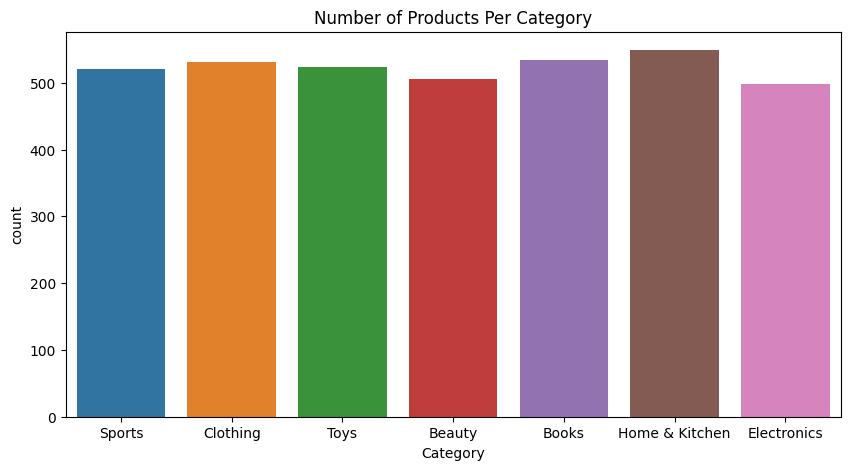

In [41]:
# Visualization 

plt.figure(figsize=(10,5))
sns.countplot(data = df, x = "Category")
plt.title("Number of Products Per Category")
plt.show()


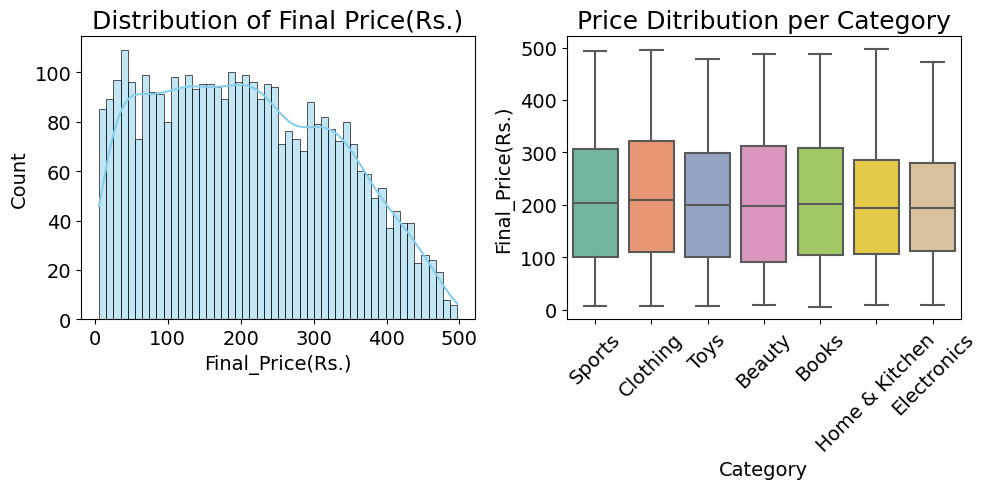

In [42]:
plt.figure(figsize =(10,5))
plt.subplot(1,2,1)
sns.histplot(df["Final_Price(Rs.)"], bins = 50, kde = True, color = "skyblue")
plt.title("Distribution of Final Price(Rs.)", fontsize = 18)
plt.xlabel("Final_Price(Rs.)",fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.subplot(1,2,2)
sns.boxplot(data = df, x = "Category", y = "Final_Price(Rs.)", palette = "Set2")
plt.title("Price Ditribution per Category", fontsize = 18)
plt.xlabel("Category",fontsize = 14)
plt.ylabel("Final_Price(Rs.)",fontsize = 14)
plt.xticks(rotation = 45, fontsize = 14)
plt.yticks(fontsize = 14)

plt.tight_layout()
plt.show()


In [43]:
# Data Cleaning Checks

print(f"Missing Values:\n {df.isnull().sum()}")
print(f"Duplicate Rows\n  {df.duplicated().sum()}")

Missing Values:
 User_ID             0
Product_ID          0
Category            0
Price (Rs.)         0
Discount (%)        0
Final_Price(Rs.)    0
Payment_Method      0
Purchase_Date       0
dtype: int64
Duplicate Rows
  0


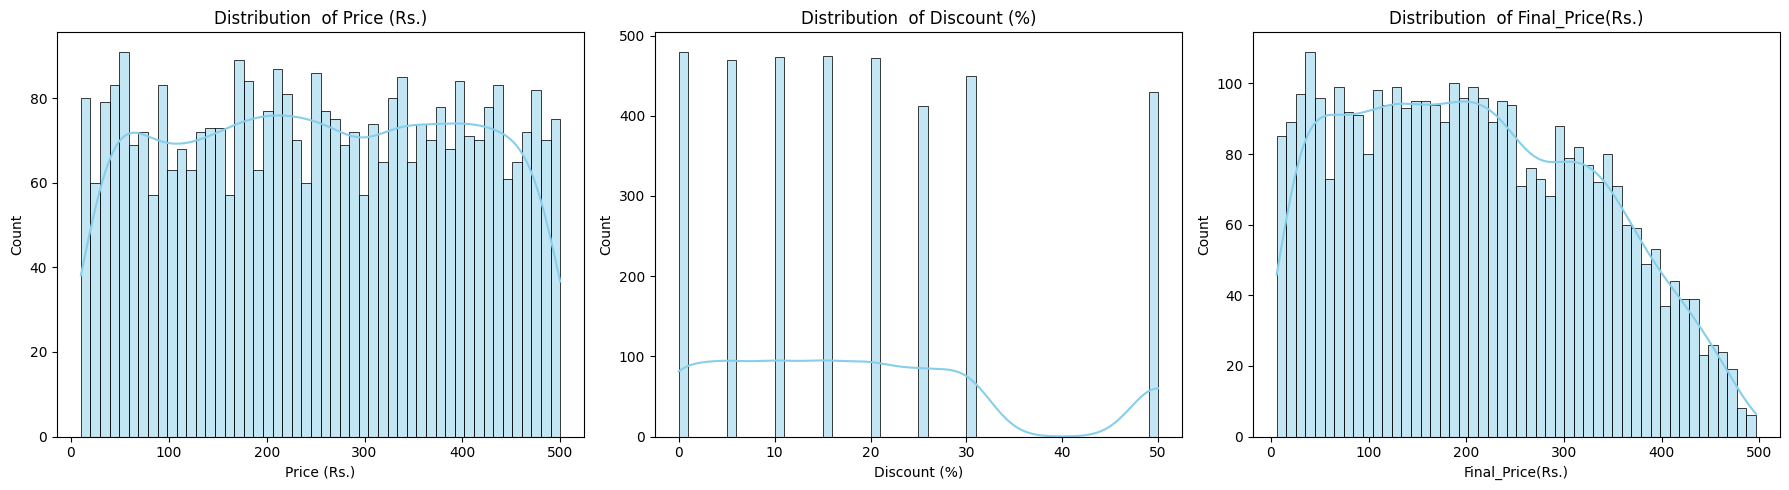

In [44]:
# Distribution Of Numeric Features 

numeric_cols = ["Price (Rs.)", "Discount (%)", "Final_Price(Rs.)"]

fig, axes = plt.subplots(1,3,figsize =(18,5))

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col],bins = 50, kde = True, color = "skyblue", ax = axes[i])
    axes[i].set_title(f"Distribution  of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

**CUSTOMER-LEVEL FEATURE ENGINEERING**

In [45]:
# Customer-level feature engineering 

customer_df = df.groupby("User_ID").agg(
    Monetory = ("Final_Price(Rs.)", "sum"),     # Total spent(target)
    Frequency = ("Final_Price(Rs.)", "count"),  # No. of purchases 
    ProductDiversity = ("Category", "nunique"), # Unique categories bought 
    AvgPrice = ("Price (Rs.)", "mean"),         # Avg listed price 
    AvgDiscount = ("Discount (%)", "mean")      # Avg discount used 
).reset_index()

print(customer_df.head())

# Replace inf values with NaN 

customer_df["Monetory"] = customer_df["Monetory"].replace([np.inf, -np.inf], np.nan)

# Drop Rows with Nan Values in Monetory Column 

customer_df = customer_df.dropna(subset = ["Monetory"])


print("Positive infinity:", np.isinf(customer_df["Monetory"]).sum())
print("Negative infinity:", np.isneginf(customer_df["Monetory"]).sum())



    User_ID  Monetory  Frequency  ProductDiversity  AvgPrice  AvgDiscount
0  001ae40d    345.93          1                 1    432.41         20.0
1  00209791     10.32          1                 1     12.14         15.0
2  0021e458    123.51          1                 1    145.31         15.0
3  00333c7a      8.65          1                 1     11.54         25.0
4  00390cf5     96.32          1                 1    137.60         30.0
Positive infinity: 0
Negative infinity: 0


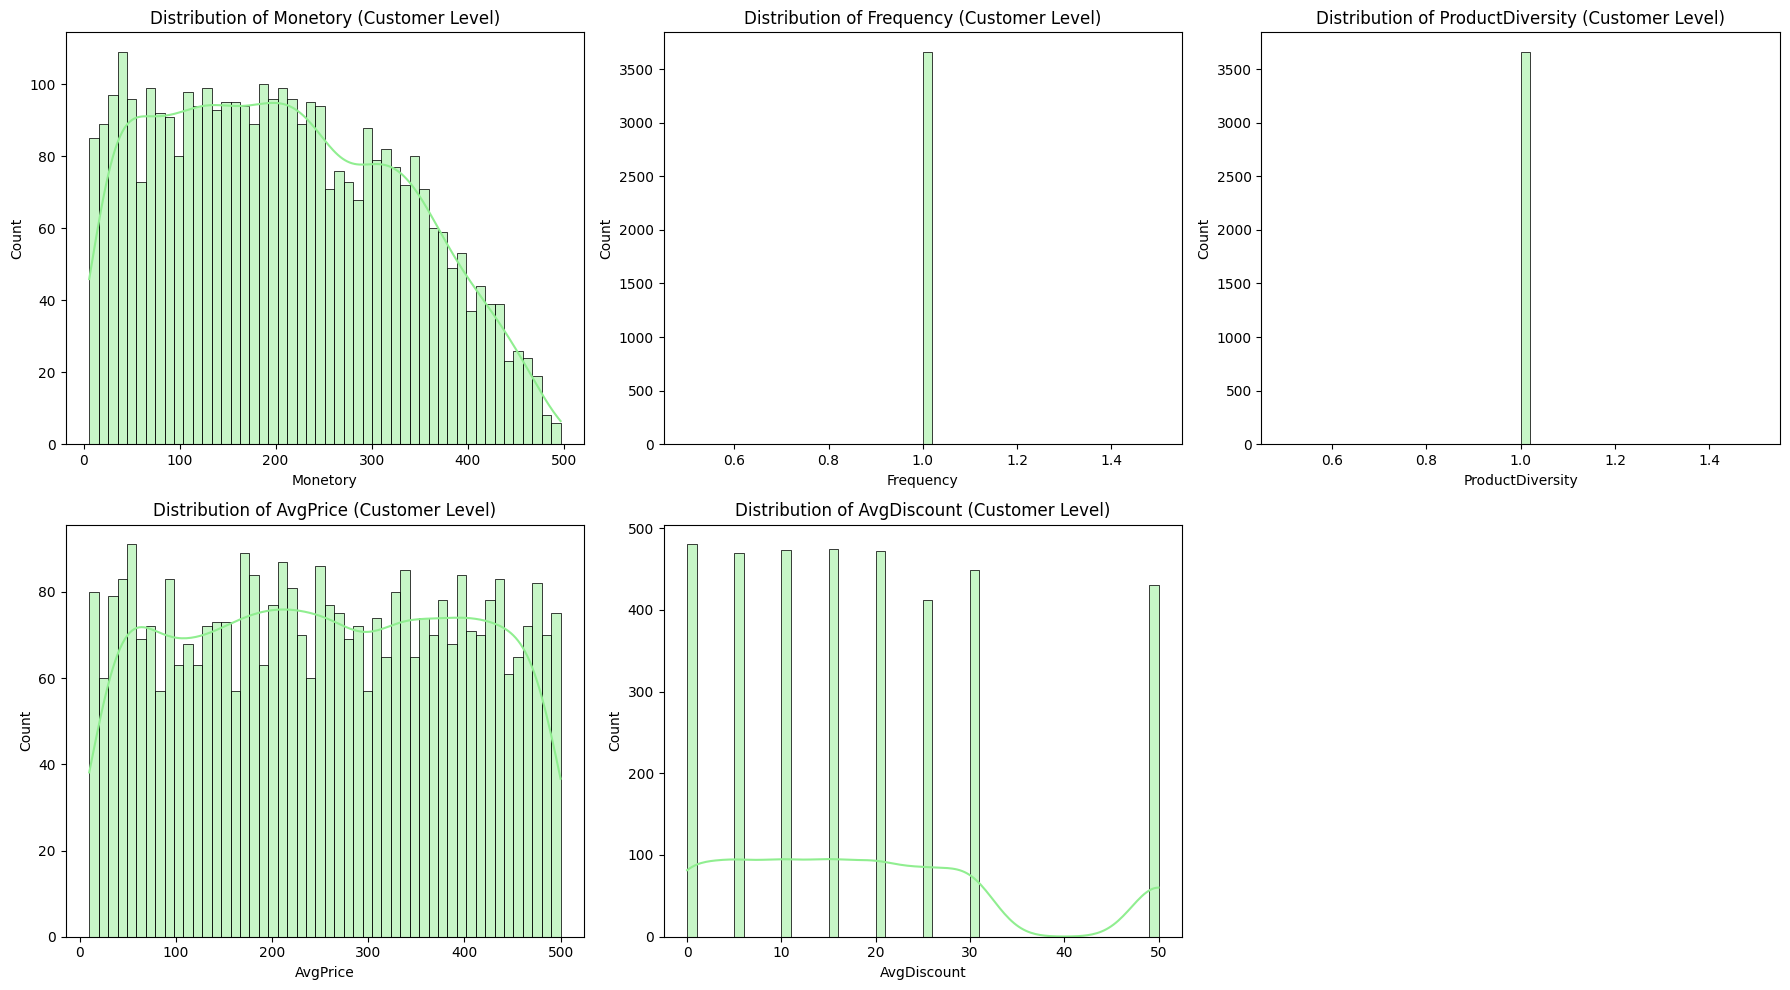

In [46]:
# Distribution of Customer Level Features 

agg_features = ["Monetory", "Frequency", "ProductDiversity", "AvgPrice", "AvgDiscount"]

fig, axes = plt.subplots(2,3,figsize = (18,10))

axes = axes.flatten()

for i , col in enumerate(agg_features):
    sns.histplot(customer_df[col], bins = 50, kde = True, color = "lightgreen", ax = axes[i])
    axes[i].set_title(f"Distribution of {col} (Customer Level)")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

axes[-1].axis("off")
plt.tight_layout()
plt.show()
    

**DEFINE TARGETS**

In [47]:
# Regression Target(CLV - CUSTOMER LIFETIME  VALUE)

y_reg = customer_df["Monetory"]

# Classification Target(HIGH VS LOW CLV)


threshold = customer_df["Monetory"].quantile(0.8) # Top 20 % value

y_class = (customer_df["Monetory"]>= threshold).astype(int)


# Features 

X = customer_df[["Frequency","ProductDiversity", "AvgPrice", "AvgDiscount"]]

print(y_reg.shape)
print(y_class.shape)
print(X.shape)
print(y_class[-5:-1])

(3660,)
(3660,)
(3660, 4)
3655    1
3656    0
3657    0
3658    0
Name: Monetory, dtype: int64


**HIGH VS LOW VALUE CUSTOMERS**

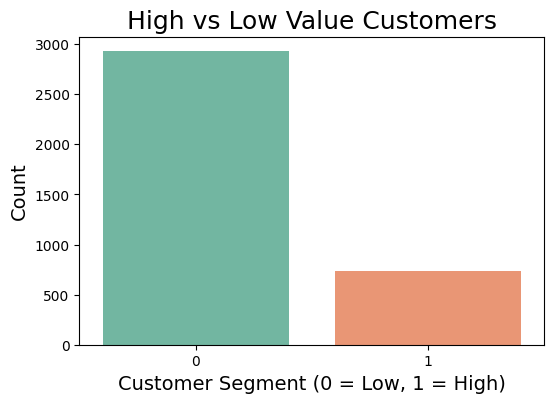

In [78]:
plt.figure(figsize =(6,4))
sns.countplot(x = y_class, palette = "Set2")
plt.title("High vs Low Value Customers", fontsize = 18)
plt.xlabel("Customer Segment (0 = Low, 1 = High)", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.show()

**TRAIN-TEST SPLIT AND SCALING (DATA PREPROCESSING)**

In [49]:
X_train,X_test,y_reg_train,y_reg_test = train_test_split(X,y_reg,test_size = 0.2, random_state = 42)
X_train,X_test,y_class_train,y_class_test = train_test_split(X,y_class,test_size = 0.2, random_state = 42 )


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(2928, 4)
(732, 4)


**REGRESSION MODELS**

In [57]:
# Linear Regression 

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_reg_train)
y_reg_pred_lin = lin_reg.predict(X_test_scaled)

# Neural Network Regressor With Tensoflow & keras

nn_model_reg = Sequential([
    tf.keras.Input(shape = (X_train_scaled.shape[1],)),
    Dense(units = 64, activation = "relu",kernel_regularizer = regularizers.l2(0.001)),
    Dense(units = 32, activation = "relu",kernel_regularizer  = regularizers.l2(0.001)),
    Dense(units = 1,  activation = "linear")
])

nn_model_reg.compile(
    loss = tf.keras.losses.mse,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
)

history = nn_model_reg.fit(
    X_train_scaled, y_reg_train,
    validation_split = 0.2,
    epochs = 100,
    batch_size = 32,
    verbose = 1
)

y_reg_pred_nn = nn_model_reg.predict(X_test_scaled).flatten()





Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 58957.6875 - val_loss: 56583.5820
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54406.7656 - val_loss: 47372.2383
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42565.4766 - val_loss: 24702.2305
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18376.1641 - val_loss: 4639.9438
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3041.3728 - val_loss: 870.8317
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 841.4199 - val_loss: 669.3712
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 632.2101 - val_loss: 563.0162
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 540.0545 - val_loss: 473.9090
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 469.8429 - val_loss: 399.3017
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 390.4517 - val_loss: 338.2132
Epoch 11/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 321.6542 - val_loss: 288.6019
Epo

**EVALUATION**

In [58]:
print("REGRESSION METRICS:")
print(f"Linear Regression RMSE:   {np.sqrt(mean_squared_error(y_reg_test,y_reg_pred_lin))}")
print(f"Linear Regression R2 SCORE:      {r2_score(y_reg_test,y_reg_pred_lin)}")
print(f"Neural Network RMSE:      {np.sqrt(mean_squared_error(y_reg_test,y_reg_pred_nn))}")
print(f"Neural Network R2 SCORE:   {r2_score(y_reg_test, y_reg_pred_nn)}")




REGRESSION METRICS:
Linear Regression RMSE:   21.441647305082157
Linear Regression R2 SCORE:      0.9689724892095697
Neural Network RMSE:      0.9557856207320999
Neural Network R2 SCORE:   0.9999383473676248


**PLOT TRAINING DATA**

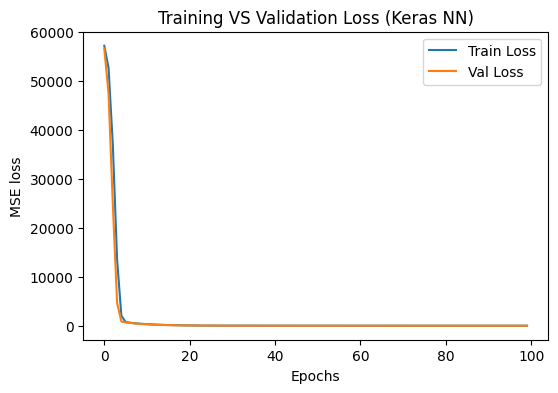

In [59]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"], label = "Val Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.title("Training VS Validation Loss (Keras NN)")
plt.legend()
plt.show()

**CLASSIFICATION MODELS**

In [61]:

# Logistic Regression

log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_class_train)
y_class_pred_log = log_reg.predict(X_test_scaled)

# Neural Network Classifier with Tensorflow & Keras 

nn_model_clf = Sequential([
    tf.keras.Input(shape = (X_train_scaled.shape[1],)),
    Dense(units = 64, activation = "relu",kernel_regularizer = regularizers.l2(0.001)),
    Dense(units = 32, activation = "relu",kernel_regularizer = regularizers.l2(0.001)),
    Dense(units = 1,  activation = "linear")
])

nn_model_clf.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ["accuracy"]
)

history_clf = nn_model_clf.fit(
    
    X_train_scaled, y_class_train, 
    validation_split = 0.2, 
    epochs = 100, 
    batch_size = 32, 
    verbose = 1
    
)

logits = nn_model_clf.predict(X_test_scaled)
probs = tf.sigmoid(logits).numpy()
                             
y_class_pred_nn = (probs>=0.5).astype(int).flatten()



Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8065 - loss: 0.5636 - val_accuracy: 0.9096 - val_loss: 0.2805
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9421 - loss: 0.2352 - val_accuracy: 0.9573 - val_loss: 0.1751
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9663 - loss: 0.1550 - val_accuracy: 0.9625 - val_loss: 0.1367
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9743 - loss: 0.1240 - val_accuracy: 0.9693 - val_loss: 0.1142
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9742 - loss: 0.1036 - val_accuracy: 0.9812 - val_loss: 0.0986
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9839 - loss: 0.0895 - val_accuracy: 0.9898 - val_loss: 0.0895
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9888 - loss: 0.0782 - val_accuracy: 0.9727 - val_loss: 0.0846
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9861 - loss: 0.0729 - val_accuracy: 0.9744 - v

**EVALUATION**

In [63]:
def evaluate_classification(y_true,y_pred,model_name):
    print(f"{model_name} RESULTS")
    print(f"Accuracy: {accuracy_score(y_true,y_pred)}")
    print(f"Confusion Matrix: {confusion_matrix(y_true,y_pred)}")
    print(f"Precision:{precision_score(y_true,y_pred)}")
    print(f"Recall: {recall_score(y_true,y_pred)}")
    print(f"Classification Report:{classification_report(y_true,y_pred)}")


evaluate_classification(y_class_test, y_class_pred_log, "LOGISTIC REGRESSION")
evaluate_classification(y_class_test, y_class_pred_log, "NEURAL NETWORK")


LOGISTIC REGRESSION RESULTS
Accuracy: 0.9972677595628415
Confusion Matrix: [[589   0]
 [  2 141]]
Precision:1.0
Recall: 0.986013986013986
Classification Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00       589
           1       1.00      0.99      0.99       143

    accuracy                           1.00       732
   macro avg       1.00      0.99      1.00       732
weighted avg       1.00      1.00      1.00       732

NEURAL NETWORK RESULTS
Accuracy: 0.9972677595628415
Confusion Matrix: [[589   0]
 [  2 141]]
Precision:1.0
Recall: 0.986013986013986
Classification Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00       589
           1       1.00      0.99      0.99       143

    accuracy                           1.00       732
   macro avg       1.00      0.99      1.00       732
weighted avg       1.00      1.00      1.00       732



**PLOT TRAINING DATA**

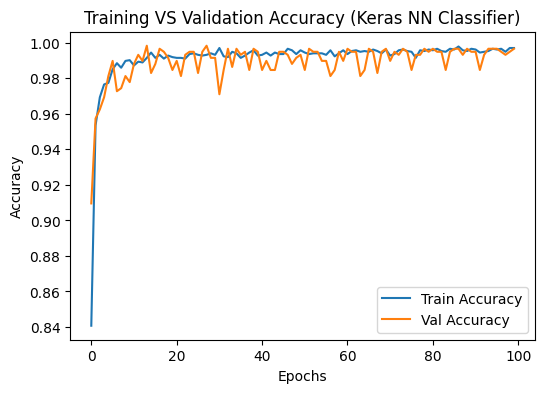

In [64]:
plt.figure(figsize=(6,4))
plt.plot(history_clf.history["accuracy"], label = "Train Accuracy")
plt.plot(history_clf.history["val_accuracy"], label = "Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training VS Validation Accuracy (Keras NN Classifier)")
plt.legend()
plt.show()

**VISUALIZATION OF PREDICTIONS**

**1. REGRESSION : ACTUAL VS PREDICTED CLV**

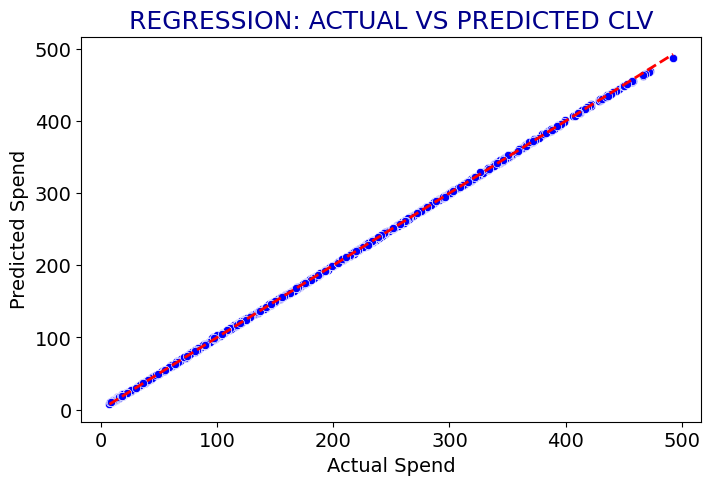

In [75]:
plt.figure(figsize = (8,5))
sns.scatterplot(x = y_reg_test, y=y_reg_pred_nn, color = "blue")
plt.title("REGRESSION: ACTUAL VS PREDICTED CLV", fontsize = 18, color = "Darkblue")
plt.xlabel("Actual Spend", fontsize = 14)
plt.ylabel("Predicted Spend", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()],
         color='red', linestyle='--', linewidth=2)


plt.show()


**2. CLASSIFICATION: PREDICTED HIGH VALUE VS LOW VALUE CUSTOMERS**

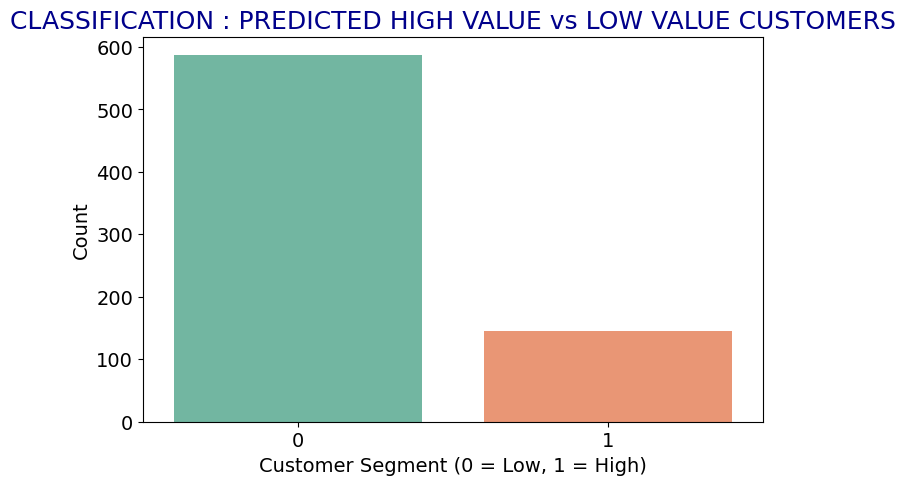

In [79]:
plt.figure(figsize = (8,5))
sns.countplot(x = y_class_pred_nn, palette = "Set2")
plt.title("CLASSIFICATION : PREDICTED HIGH VALUE vs LOW VALUE CUSTOMERS", fontsize = 18,color = "Darkblue")
plt.xlabel("Customer Segment (0 = Low, 1 = High)",fontsize = 14)
plt.ylabel("Count",fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()
